# Setup

In [ ]:
from google.colab import drive
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Data Pipeline


In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

file_path = "/content/drive/MyDrive/24fall_dlProject/BTC-USD_stock_data.csv"

data = pd.read_csv(file_path,index_col='Date',parse_dates=['Date'])

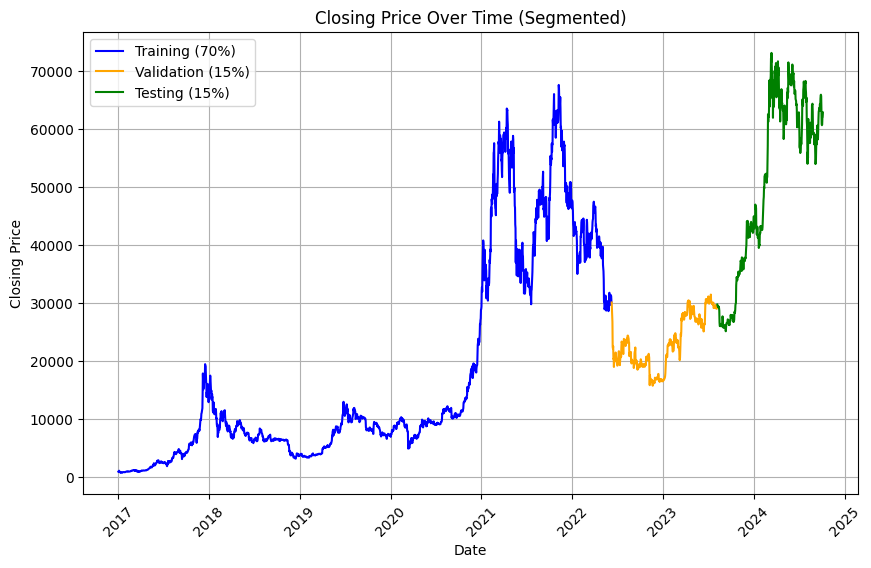

In [ ]:
close_data = data['Close'].values  # Get 'Close' data as a NumPy array
total_data_points = len(close_data)
segment1_end = int(total_data_points * 0.7)
segment2_end = int(total_data_points * (0.7 + 0.15))

plt.figure(figsize=(10, 6))

# Plotting segments with different colors
plt.plot(data.index[:segment1_end], close_data[:segment1_end], label='Training (70%)', color='blue')
plt.plot(data.index[segment1_end:segment2_end], close_data[segment1_end:segment2_end], label='Validation (15%)', color='orange')
plt.plot(data.index[segment2_end:], close_data[segment2_end:], label='Testing (15%)', color='green')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price Over Time (Segmented)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
def data_preprocessing_with_closed_price_and_min_max_scaler(data, seq_length=60):
    train_ratio = 0.7
    val_ratio = 0.15
    close_data = data["Close"].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 10))
    data_scaled = scaler.fit_transform(close_data)
    data_scaled = pd.DataFrame(data_scaled, columns=["Close"])

    def create_feature_datasets(data, x_size):
        x_datasets = []
        y_datasets = []
        for i in range(len(data) - x_size):
            x = data[i:i + x_size].values.reshape(-1, 1)
            y = data[i + x_size:i + x_size + 1].values.reshape(1)
            x_datasets.append(x)
            y_datasets.append(y)
        X = np.array(x_datasets)
        y = np.array(y_datasets)
        X_train =  X[:int(len(X) * train_ratio)]
        y_train = y[:int(len(y) * train_ratio)]
        X_val = X[int(len(X) * train_ratio):int(len(X) * (train_ratio + val_ratio))]
        y_val = y[int(len(y) * train_ratio):int(len(y) * (train_ratio + val_ratio))]
        X_test = X[int(len(X) * (train_ratio + val_ratio)):]
        y_test = y[int(len(y) * (train_ratio + val_ratio)):]

        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        return torch.Tensor(X_train_shuffled), torch.Tensor(X_val), torch.Tensor(X_test), torch.Tensor(y_train_shuffled), torch.Tensor(y_val), torch.Tensor(y_test)

    return create_feature_datasets(data_scaled, seq_length), scaler

(X_train, X_val, X_test, y_train, y_val, y_test), min_max_scaler = data_preprocessing_with_closed_price_and_min_max_scaler(data, 60)

# Baseline Model

In [ ]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size)  # Initial hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size)  # Initial cell state
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Get the output from the last time step
        return out

# Training

In [ ]:
# create a nn class (just-for-fun choice :-)
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [ ]:
# Hyperparameters
input_size = 1
hidden_size = 64
num_layers = 2
dropout = 0.2
output_size = 1
learning_rate = 0.0001
num_epochs = 200
batch_size = 64

# Create dataset and DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_losses = []

# Training loop with batching
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    epoch_losses.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/200], Loss: 1.6349
Epoch [10/200], Loss: 0.1462
Epoch [15/200], Loss: 0.4645
Epoch [20/200], Loss: 0.3435
Epoch [25/200], Loss: 0.1764
Epoch [30/200], Loss: 0.1896
Epoch [35/200], Loss: 0.3614
Epoch [40/200], Loss: 0.1914
Epoch [45/200], Loss: 0.1726
Epoch [50/200], Loss: 0.1451
Epoch [55/200], Loss: 0.1753
Epoch [60/200], Loss: 0.1106
Epoch [65/200], Loss: 0.1441
Epoch [70/200], Loss: 0.1368
Epoch [75/200], Loss: 0.2528
Epoch [80/200], Loss: 0.1589
Epoch [85/200], Loss: 0.1721
Epoch [90/200], Loss: 0.2152
Epoch [95/200], Loss: 0.1780
Epoch [100/200], Loss: 0.1043
Epoch [105/200], Loss: 0.2056
Epoch [110/200], Loss: 0.1704
Epoch [115/200], Loss: 0.1853
Epoch [120/200], Loss: 0.1315
Epoch [125/200], Loss: 0.1255
Epoch [130/200], Loss: 0.1338
Epoch [135/200], Loss: 0.1778
Epoch [140/200], Loss: 0.1129
Epoch [145/200], Loss: 0.0956
Epoch [150/200], Loss: 0.0979
Epoch [155/200], Loss: 0.1531
Epoch [160/200], Loss: 0.1434
Epoch [165/200], Loss: 0.2155
Epoch [170/200], Loss: 0.1426


# Visualization

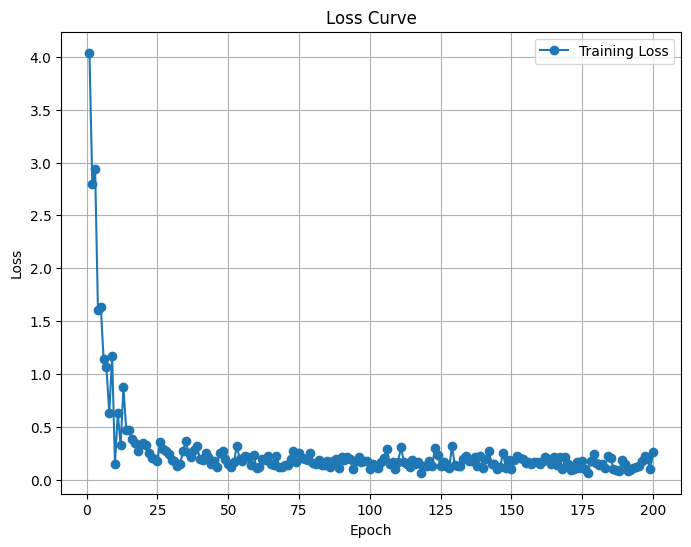

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_train)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_train) ** 2))
print(f"Training Loss Scaling Unreversed: {rmse.item()}")

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(predictions.numpy()))
y_train_reversed = torch.Tensor(min_max_scaler.inverse_transform(y_train.numpy()))
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_train_reversed) ** 2))
print(f"Training Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 0.3999
Training Loss Scaling Unreversed: 0.14319120347499847
Training Loss Scaling Reversed: 1035.3546142578125


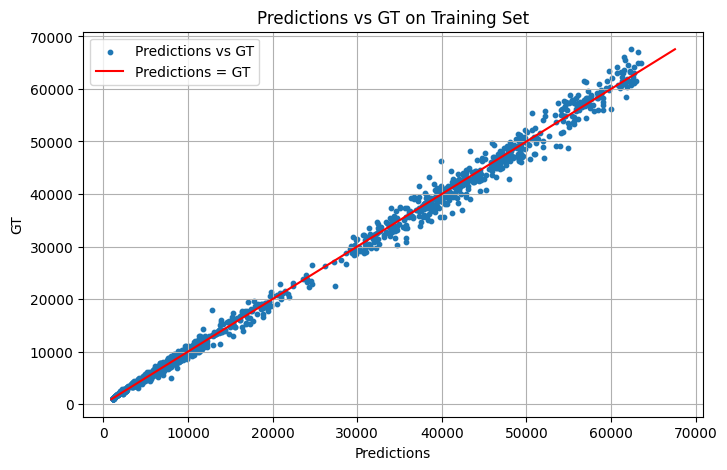

In [ ]:

# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.scatter(tensor1.numpy(), tensor2.numpy(), label='Predictions vs GT', marker='o', s=10)

min_val = min(tensor1.min(), tensor2.min())
max_val = max(tensor1.max(), tensor2.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', label='Predictions = GT')

plt.title('Predictions vs GT on Training Set')
plt.xlabel('Predictions')
plt.ylabel('GT')
plt.legend()
plt.grid(True)
plt.show()

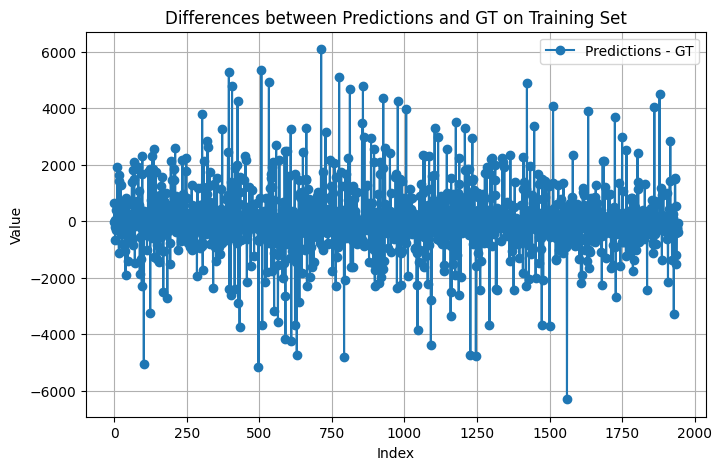

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Training Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_val)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_val) ** 2))
print(f"Training Loss Scaling Unreversed: {rmse.item()}")

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(predictions.numpy()))
y_val_reversed = torch.Tensor(min_max_scaler.inverse_transform(y_val.numpy()))
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_val_reversed) ** 2))
print(f"Training Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 2.8903
Training Loss Scaling Unreversed: 0.10722919553518295
Training Loss Scaling Reversed: 775.3286743164062


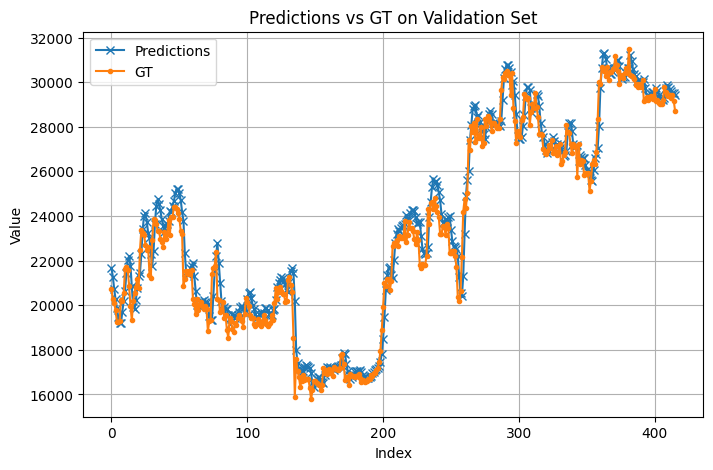

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy(), label='Predictions', marker='x')
plt.plot(tensor2.numpy(), label='GT', marker='.')
plt.title('Predictions vs GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

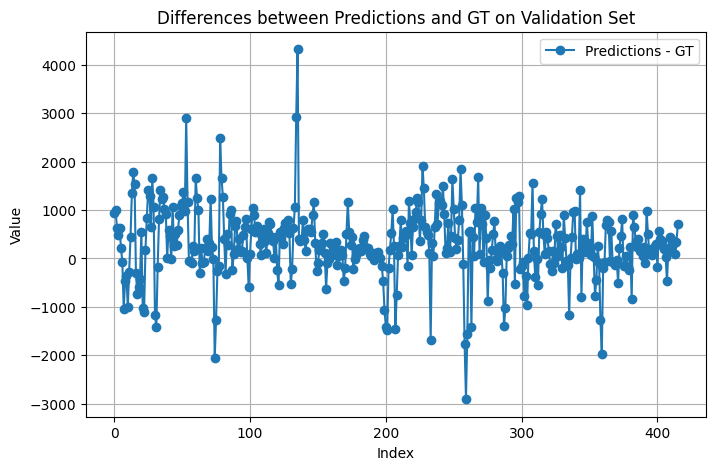

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()